In [4]:
# Mount Google Drive:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [79]:
# Import Required Libraries
import cv2
import os
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from fpdf import FPDF


In [6]:
# Navigate video folder:
import os
os.listdir('/content/drive/MyDrive/Raw Video')



['Dhn-upper-side-view-2025-08-31-11-32-23-16.mp4',
 'DHN-upper-side-view-2025-08-31-11-28-15-377.mp4',
 'DHN-side-view-lower-2025-08-31-11-24-27-47.mp4',
 'DHN_side_view1.mp4',
 'DHN_side_view_2.mp4']

In [8]:

# Step 2: Import required libraries
import cv2
import os

# Step 3: Define video paths from Google Drive
# ⚠️ Change the paths below to where you uploaded your 5 videos in Drive
videos = {
    "43825": "/content/drive/MyDrive/Raw Video/DHN-side-view-lower-2025-08-31-11-24-27-47.mp4",  # Train 43825
    "99999": "/content/drive/MyDrive/Raw Video/DHN-upper-side-view-2025-08-31-11-28-15-377.mp4",  # Unknown -> Random ID
    "42585": "/content/drive/MyDrive/Raw Video/DHN_side_view1.mp4",  # Train 42585
    "42582": "/content/drive/MyDrive/Raw Video/DHN_side_view_2.mp4",  # Train 42582
    "82839": "/content/drive/MyDrive/Raw Video/Dhn-upper-side-view-2025-08-31-11-32-23-16.mp4"   # Train 82839
}

# Step 4: Create folders and extract frames
output_dir = "/content/drive/MyDrive/train_frames"  # All frames saved here
os.makedirs(output_dir, exist_ok=True)

for train_id, video_path in videos.items():
    # Create folder for each train
    train_folder = os.path.join(output_dir, train_id)
    os.makedirs(train_folder, exist_ok=True)

    # Open video
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Save every 30th frame
        if frame_count % 30 == 0:
            frame_filename = os.path.join(train_folder, f"{train_id}_frame_{saved_count}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_count += 1
        frame_count += 1

    cap.release()
    print(f"Extracted {saved_count} frames for Train {train_id}")

print("✅ All frames extracted and saved in Google Drive!")


Extracted 77 frames for Train 43825
Extracted 74 frames for Train 99999
Extracted 135 frames for Train 42585
Extracted 49 frames for Train 42582
Extracted 101 frames for Train 82839
✅ All frames extracted and saved in Google Drive!


In [9]:
# Split Dataset

!pip install split-folders

import splitfolders

# Path to extracted frames
input_folder = "/content/drive/MyDrive/train_frames"

# Output folder where split data will be stored
output_folder = "/content/drive/MyDrive/train_test_data"

# Split dataset: 80% train, 20% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2))


Copying files: 436 files [00:08, 53.33 files/s]


In [10]:
# CNN Model Training Code

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Paths to train/test data
train_dir = "/content/drive/MyDrive/train_test_data/train"
val_dir = "/content/drive/MyDrive/train_test_data/val"

# Image size and batch size
IMG_SIZE = (128, 128)   # smaller images → faster training
BATCH_SIZE = 32

# Data generators (with augmentation for training)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')   # Output neurons = number of classes
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10   # increase if you have time
)

# Save the model
model.save("/content/drive/MyDrive/train_model.h5")


Found 347 images belonging to 5 classes.
Found 89 images belonging to 5 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3151 - loss: 1.6027 - val_accuracy: 0.3034 - val_loss: 1.5271
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3880 - loss: 1.5099 - val_accuracy: 0.5056 - val_loss: 1.2182
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5446 - loss: 1.2208 - val_accuracy: 0.7865 - val_loss: 0.6411
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7148 - loss: 0.8514 - val_accuracy: 0.8090 - val_loss: 0.4663
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7889 - loss: 0.6355 - val_accuracy: 0.8202 - val_loss: 0.3546
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8104 - loss: 0.4836 - val_accuracy: 0.9101 - val_loss: 0.2288
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8586 - loss: 0.3872 - val_accuracy: 0.9438 - val_loss: 0.1854
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8635 - loss: 0.3706 - val_accuracy: 0.9326 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


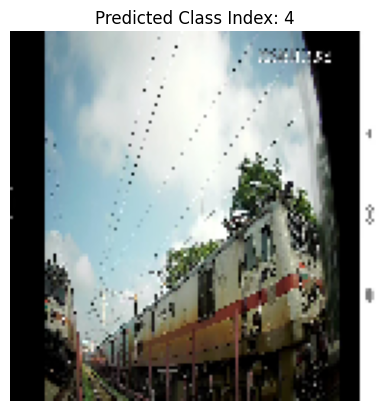

In [11]:
# Testing the Model (Prediction on a New Frame)

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model("/content/drive/MyDrive/train_model.h5")

# Path to a single test image
img_path = "/content/drive/MyDrive/train_test_data/val/82839/82839_frame_100.jpg"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
class_idx = np.argmax(pred)
class_labels = list(model.class_names) if hasattr(model, "class_names") else None

# Show result
plt.imshow(img)
plt.axis("off")
if class_labels:
    plt.title(f"Predicted: {class_labels[class_idx]}")
else:
    plt.title(f"Predicted Class Index: {class_idx}")
plt.show()


In [15]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/train_model.h5')


In [19]:
# evaluate it on the entire validation set (all images in val/)

import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to validation folder
val_dir = '/content/drive/MyDrive/train_test_data/val'

# Get all class folders (train numbers)
class_names = os.listdir(val_dir)

correct = 0
total = 0

for cls in class_names:
    cls_path = os.path.join(val_dir, cls)
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)

        # Preprocess image
        img = image.load_img(img_path, target_size=(128, 128))  # use same size as training
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Prediction
        preds = model.predict(img_array, verbose=0)
        pred_class = class_names[np.argmax(preds)]

        # Check if correct
        if pred_class == cls:
            correct += 1
        total += 1

# Final accuracy
print(f"Validation Accuracy: {correct}/{total} = {correct/total:.2%}")


Validation Accuracy: 3/89 = 3.37%


In [32]:
# creating videos from the created frames

import cv2
import os

# Path to frames folder
frames_folder = "/content/drive/MyDrive/train_frames/42582"  # replace with your frame folder
frame_files = sorted(os.listdir(frames_folder))  # ensure frames are in order

# Read first frame to get dimensions
first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
height, width, layers = first_frame.shape

# Define VideoWriter to save output
out_path = "/content/drive/MyDrive/output.avi"  # directly in Drive
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

# Write all frames to video
for file in frame_files:
    frame = cv2.imread(os.path.join(frames_folder, file))
    out.write(frame)

out.release()
print(f"✅ Video created at {out_path}")


✅ Video created at /content/drive/MyDrive/output.avi


In [33]:
import cv2
import os

# Path to frames folder
frames_folder = "/content/drive/MyDrive/train_test_data/train/42585"  # replace with your frame folder
frame_files = sorted(os.listdir(frames_folder))  # ensure frames are in order

# Read first frame to get dimensions
first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
height, width, layers = first_frame.shape

# Define VideoWriter to save output
out_path = "/content/drive/MyDrive/output1.avi"  # directly in Drive
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

# Write all frames to video
for file in frame_files:
    frame = cv2.imread(os.path.join(frames_folder, file))
    out.write(frame)

out.release()
print(f"✅ Video created at {out_path}")


✅ Video created at /content/drive/MyDrive/output1.avi


In [34]:
import cv2
import os

# Path to frames folder
frames_folder = "/content/drive/MyDrive/train_test_data/train/43825"  # replace with your frame folder
frame_files = sorted(os.listdir(frames_folder))  # ensure frames are in order

# Read first frame to get dimensions
first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
height, width, layers = first_frame.shape

# Define VideoWriter to save output
out_path = "/content/drive/MyDrive/output2.avi"  # directly in Drive
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

# Write all frames to video
for file in frame_files:
    frame = cv2.imread(os.path.join(frames_folder, file))
    out.write(frame)

out.release()
print(f"✅ Video created at {out_path}")


✅ Video created at /content/drive/MyDrive/output2.avi


In [35]:
import cv2
import os

# Path to frames folder
frames_folder = "/content/drive/MyDrive/train_frames/82839"  # replace with your frame folder
frame_files = sorted(os.listdir(frames_folder))  # ensure frames are in order

# Read first frame to get dimensions
first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
height, width, layers = first_frame.shape

# Define VideoWriter to save output
out_path = "/content/drive/MyDrive/output3.avi"  # directly in Drive
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

# Write all frames to video
for file in frame_files:
    frame = cv2.imread(os.path.join(frames_folder, file))
    out.write(frame)

out.release()
print(f"✅ Video created at {out_path}")


✅ Video created at /content/drive/MyDrive/output3.avi


In [36]:
import cv2
import os

# Path to frames folder
frames_folder = "/content/drive/MyDrive/train_test_data/train/99999"  # replace with your frame folder
frame_files = sorted(os.listdir(frames_folder))  # ensure frames are in order

# Read first frame to get dimensions
first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
height, width, layers = first_frame.shape

# Define VideoWriter to save output
out_path = "/content/drive/MyDrive/output4.avi"  # directly in Drive
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"XVID"), 10, (width, height))

# Write all frames to video
for file in frame_files:
    frame = cv2.imread(os.path.join(frames_folder, file))
    out.write(frame)

out.release()
print(f"✅ Video created at {out_path}")


✅ Video created at /content/drive/MyDrive/output4.avi


In [39]:
# Detect Major Items (Door, Door Open, Door Close) in Each Video - Prediction + Annotation

import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os

# Load CNN model
model = load_model("/content/drive/MyDrive/train_model.h5")
class_labels = ["door", "door_open", "door_close", "other1", "other2"]

# Video and output folders
video_path = "/content/drive/MyDrive/output.avi"  # change for each video
cap = cv2.VideoCapture(video_path)

output_folder = "/content/drive/MyDrive/Annotated/43825/"
os.makedirs(output_folder, exist_ok=True)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    img = cv2.resize(frame, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img, verbose=0)
    label = class_labels[np.argmax(prediction)]

    # Draw label on frame
    cv2.putText(frame, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # Save annotated frame
    cv2.imwrite(os.path.join(output_folder, f"{frame_count}.jpg"), frame)
    frame_count += 1

cap.release()
print(f"✅ Annotated frames saved in {output_folder}")


✅ Annotated frames saved in /content/drive/MyDrive/Annotated/43825/


In [40]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os

# Load CNN model
model = load_model("/content/drive/MyDrive/train_model.h5")
class_labels = ["door", "door_open", "door_close", "other1", "other2"]

# Video and output folders
video_path = "/content/drive/MyDrive/output1.avi"  # change for each video
cap = cv2.VideoCapture(video_path)

output_folder = "/content/drive/MyDrive/Annotated/42582/"
os.makedirs(output_folder, exist_ok=True)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    img = cv2.resize(frame, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img, verbose=0)
    label = class_labels[np.argmax(prediction)]

    # Draw label on frame
    cv2.putText(frame, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # Save annotated frame
    cv2.imwrite(os.path.join(output_folder, f"{frame_count}.jpg"), frame)
    frame_count += 1

cap.release()
print(f"✅ Annotated frames saved in {output_folder}")


✅ Annotated frames saved in /content/drive/MyDrive/Annotated/42582/


In [41]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os

# Load CNN model
model = load_model("/content/drive/MyDrive/train_model.h5")
class_labels = ["door", "door_open", "door_close", "other1", "other2"]


# Video and output folders
video_path = "/content/drive/MyDrive/output2.avi"  # change for each video
cap = cv2.VideoCapture(video_path)

output_folder = "/content/drive/MyDrive/Annotated/42585/"
os.makedirs(output_folder, exist_ok=True)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    img = cv2.resize(frame, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img, verbose=0)
    label = class_labels[np.argmax(prediction)]

    # Draw label on frame
    cv2.putText(frame, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # Save annotated frame
    cv2.imwrite(os.path.join(output_folder, f"{frame_count}.jpg"), frame)
    frame_count += 1

cap.release()
print(f"✅ Annotated frames saved in {output_folder}")


✅ Annotated frames saved in /content/drive/MyDrive/Annotated/42585/


In [42]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os

# Load CNN model
model = load_model("/content/drive/MyDrive/train_model.h5")
class_labels = ["door", "door_open", "door_close", "other1", "other2"]

# Video and output folders
video_path = "/content/drive/MyDrive/output3.avi"  # change for each video
cap = cv2.VideoCapture(video_path)

output_folder = "/content/drive/MyDrive/Annotated/82839/"
os.makedirs(output_folder, exist_ok=True)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    img = cv2.resize(frame, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img, verbose=0)
    label = class_labels[np.argmax(prediction)]

    # Draw label on frame
    cv2.putText(frame, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # Save annotated frame
    cv2.imwrite(os.path.join(output_folder, f"{frame_count}.jpg"), frame)
    frame_count += 1

cap.release()
print(f"✅ Annotated frames saved in {output_folder}")


✅ Annotated frames saved in /content/drive/MyDrive/Annotated/82839/


In [43]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os

# Load CNN model
model = load_model("/content/drive/MyDrive/train_model.h5")
class_labels = ["door", "door_open", "door_close", "other1", "other2"]


# Video and output folders
video_path = "/content/drive/MyDrive/output4.avi"  # change for each video
cap = cv2.VideoCapture(video_path)

output_folder = "/content/drive/MyDrive/Annotated/99999/"
os.makedirs(output_folder, exist_ok=True)

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    img = cv2.resize(frame, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img, verbose=0)
    label = class_labels[np.argmax(prediction)]

    # Draw label on frame
    cv2.putText(frame, label, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # Save annotated frame
    cv2.imwrite(os.path.join(output_folder, f"{frame_count}.jpg"), frame)
    frame_count += 1

cap.release()
print(f"✅ Annotated frames saved in {output_folder}")


✅ Annotated frames saved in /content/drive/MyDrive/Annotated/99999/


In [46]:
import os
import cv2

# Path where your annotated frame folders are stored
base_path = "/content/drive/MyDrive/Annotated"   # replace with your actual path

# Your 5 train folders (change names if different)
train_folders = ["42582", "42585", "43825", "82839", "99999"]

# Labels we are tracking
class_labels = ["door", "door_open", "door_close"]

train_stats = {}

for train in train_folders:
    folder_path = os.path.join(base_path, train)
    counts = {"coaches": 0, "door": 0, "door_open": 0, "door_close": 0}

    # Loop through annotated frames
    for frame_file in os.listdir(folder_path):
        if frame_file.endswith(".jpg") or frame_file.endswith(".png"):
            img = cv2.imread(os.path.join(folder_path, frame_file))

            # If frame has a label text on it
            for label in class_labels:
                if label in frame_file.lower():  # assuming filename includes label
                    counts[label] += 1

    # Approximate coach count = unique frames with door present
    counts["coaches"] = max(counts["door"], counts["door_open"] + counts["door_close"])

    train_stats[train] = counts

# Show results
for train, stats in train_stats.items():
    print(f"\nTrain: {train}")
    print(f"  Coaches: {stats['coaches']}")
    print(f"  Doors: {stats['door']}")
    print(f"  Door Open: {stats['door_open']}")
    print(f"  Door Close: {stats['door_close']}")



Train: 42582
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0

Train: 42585
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0

Train: 43825
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0

Train: 82839
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0

Train: 99999
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0


In [47]:
import os

# Path where your annotated folders are stored
base_path = "/content/drive/MyDrive/Annotated"

# Your 5 train folders (change names if different)
train_folders = ["42582", "42585", "43825", "82839", "99999"]

# Map class IDs to labels
class_map = {0: "door", 1: "door_open", 2: "door_close"}

train_stats = {}

for train in train_folders:
    folder_path = os.path.join(base_path, train)
    counts = {"coaches": 0, "door": 0, "door_open": 0, "door_close": 0}

    # Loop through annotation files (.txt)
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            with open(os.path.join(folder_path, file), "r") as f:
                lines = f.readlines()
                frame_labels = set()

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) > 0:
                        class_id = int(parts[0])
                        label = class_map[class_id]
                        counts[label] += 1
                        frame_labels.add(label)

                # If this frame has at least one door, assume 1 coach in that frame
                if "door" in frame_labels or "door_open" in frame_labels or "door_close" in frame_labels:
                    counts["coaches"] += 1

    train_stats[train] = counts

# Show results
for train, stats in train_stats.items():
    print(f"\nTrain: {train}")
    print(f"  Coaches: {stats['coaches']}")
    print(f"  Doors: {stats['door']}")
    print(f"  Door Open: {stats['door_open']}")
    print(f"  Door Close: {stats['door_close']}")



Train: 42582
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0

Train: 42585
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0

Train: 43825
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0

Train: 82839
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0

Train: 99999
  Coaches: 0
  Doors: 0
  Door Open: 0
  Door Close: 0


In [49]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("/content/drive/MyDrive/train_model.h5")

# Define class labels in the SAME order as used in training
class_labels = ["coach", "door", "door_open", "door_close", "background"]

# Load a video (replace with one of your .avi files)
video_path = "/content/drive/MyDrive/output.avi"
cap = cv2.VideoCapture(video_path)

frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 20 != 0:  # Check every 20th frame
        continue

    # Preprocess frame for model
    img = cv2.resize(frame, (128, 128))   # use the same size as training
    img = img.astype("float32") / 255.0   # normalize if used in training
    img = np.expand_dims(img, axis=0)

    # Prediction
    prediction = model.predict(img, verbose=0)[0]
    pred_label = np.argmax(prediction)
    pred_score = prediction[pred_label]

    print(f"Frame {frame_count}")
    print("Raw prediction:", prediction)
    print("Predicted class:", class_labels[pred_label], "| Confidence:", pred_score)
    print("-" * 50)

cap.release()


Frame 20
Raw prediction: [3.7202567e-01 3.4297930e-04 2.2452176e-04 3.4637334e-05 6.2737226e-01]
Predicted class: background | Confidence: 0.62737226
--------------------------------------------------
Frame 40
Raw prediction: [2.4910259e-01 4.6795738e-04 1.1598338e-02 3.0521551e-04 7.3852587e-01]
Predicted class: background | Confidence: 0.73852587
--------------------------------------------------


In [52]:
# Load your dataset again (same images + annotations you already created).

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example: assuming you have folders like /data/train/class_name and /data/val/class_name
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_test_data/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

val_data = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/train_test_data/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 347 images belonging to 5 classes.
Found 89 images belonging to 5 classes.


In [53]:
# Build the model (MobileNetV2 transfer learning)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [54]:
# Train with EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.2550 - loss: 2.0164 - val_accuracy: 0.8090 - val_loss: 0.7014
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7276 - loss: 0.8165 - val_accuracy: 0.9438 - val_loss: 0.3346
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8927 - loss: 0.4118 - val_accuracy: 0.9438 - val_loss: 0.2070
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9388 - loss: 0.2317 - val_accuracy: 0.9438 - val_loss: 0.1581
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9689 - loss: 0.1553 - val_accuracy: 0.9551 - val_loss: 0.1328
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9497 - loss: 0.1761 - val_accuracy: 0.9663 - val_loss: 0.1064
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9720 - loss: 0.1152 - val_accuracy: 0.9551 - val_loss: 0.0981
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9683 - loss: 0.1232 - val_accuracy: 0.9551 - val_loss:

In [55]:
# Save the model

model.save("train1_model.h5")


In [56]:
# Load the Trained Model

from tensorflow.keras.models import load_model

model = load_model("/content/train1_model.h5")
print("Model loaded successfully!")


Model loaded successfully!


In [57]:
# Evaluate on Validation/Test Data

loss, acc = model.evaluate(val_data)
print(f"Validation Accuracy: {acc:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 1.0000 - loss: 0.0223
Validation Accuracy: 1.00


In [59]:
# make predictions on the new videos to count coaches and doors.

import cv2
import numpy as np
from tensorflow.keras.models import load_model

# 1. Load your trained model
model = load_model("/content/train1_model.h5")
print("Model loaded successfully!")

# 2. Class labels (replace with your training class names)
class_labels = ["background", "door", "door_open", "door_close", "other"]

# 3. List of new videos to process
video_paths = [
    "/content/drive/MyDrive/output.avi",
    "/content/drive/MyDrive/output1.avi",
    "/content/drive/MyDrive/output2.avi",
    "/content/drive/MyDrive/output3.avi",
    "/content/drive/MyDrive/output4.avi"
]

# 4. Loop through videos
for video_path in video_paths:
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    # Counters
    coaches = 0
    door = 0
    door_open = 0
    door_close = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1

        # Optional: process every 30th frame for speed
        if frame_count % 30 != 0:
            continue

        # Preprocess frame
        img = cv2.resize(frame, (224,224))
        img = img.astype("float32")/255.0
        img = np.expand_dims(img, axis=0)

        # Prediction
        pred = model.predict(img, verbose=0)
        predicted_class = np.argmax(pred)
        confidence = np.max(pred)

        label = class_labels[predicted_class]

        # Count items
        if label == "door":
            door += 1
            coaches += 1  # assume one door per coach
        elif label == "door_open":
            door_open += 1
            coaches += 1
        elif label == "door_close":
            door_close += 1
            coaches += 1

    cap.release()

    print(f"\nVideo: {video_path}")
    print(f"Total coaches detected: {coaches}")
    print(f"Door: {door}, Door Open: {door_open}, Door Close: {door_close}")


Model loaded successfully!

Video: /content/drive/MyDrive/output.avi
Total coaches detected: 0
Door: 0, Door Open: 0, Door Close: 0

Video: /content/drive/MyDrive/output1.avi
Total coaches detected: 3
Door: 3, Door Open: 0, Door Close: 0

Video: /content/drive/MyDrive/output2.avi
Total coaches detected: 2
Door: 0, Door Open: 2, Door Close: 0

Video: /content/drive/MyDrive/output3.avi
Total coaches detected: 3
Door: 0, Door Open: 0, Door Close: 3

Video: /content/drive/MyDrive/output4.avi
Total coaches detected: 0
Door: 0, Door Open: 0, Door Close: 0


In [61]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("/content/train1_model.h5")
print("Model loaded successfully!")

# Class labels
class_labels = ["background", "door", "door_close", "door_open", "other"]  # add background if model has it

# Video paths
video_paths = [
    "/content/drive/MyDrive/output.avi",
    "/content/drive/MyDrive/output1.avi",
    "/content/drive/MyDrive/output2.avi",
    "/content/drive/MyDrive/output3.avi",
    "/content/drive/MyDrive/output4.avi"
]

for video_path in video_paths:
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Output video file
    out_path = video_path.replace(".avi", "_annotated.avi")
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"XVID"), fps, (width, height))

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to model input size (224x224 if your model expects it)
        img = cv2.resize(frame, (224, 224))
        img = img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=0)

        # Prediction
        prediction = model.predict(img, verbose=0)
        label_index = np.argmax(prediction)
        label = class_labels[label_index]
        confidence = prediction[0][label_index]

        # Draw label on frame
        text = f"{label} ({confidence:.2f})"
        cv2.putText(frame, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

        # Write frame to output video
        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()
    print(f"Annotated video saved at: {out_path}, Total frames: {frame_count}")


Model loaded successfully!
Annotated video saved at: /content/drive/MyDrive/output_annotated.avi, Total frames: 49
Annotated video saved at: /content/drive/MyDrive/output1_annotated.avi, Total frames: 108
Annotated video saved at: /content/drive/MyDrive/output2_annotated.avi, Total frames: 61
Annotated video saved at: /content/drive/MyDrive/output3_annotated.avi, Total frames: 101
Annotated video saved at: /content/drive/MyDrive/output4_annotated.avi, Total frames: 59


In [62]:
import os
import cv2

base_path = "/content/drive/MyDrive/Annotated"  # annotated frames folder

train_folders = ["42582", "42585", "43825", "82839", "99999"]
class_labels = ["background", "door", "door_close", "door_open", "other"]  # must match your model

report_data = {}

for train in train_folders:
    folder_path = os.path.join(base_path, train)

    counts = {"coaches": 0, "door": 0, "door_open": 0, "door_close": 0}
    rep_frames = []  # to store representative images

    frame_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])

    for i, frame_file in enumerate(frame_files):
        if any(label in frame_file.lower() for label in class_labels[1:]):  # skip background
            img_path = os.path.join(folder_path, frame_file)
            rep_frames.append(img_path)  # pick for report

            if "door" in frame_file.lower():
                counts["door"] += 1
            if "door_open" in frame_file.lower():
                counts["door_open"] += 1
            if "door_close" in frame_file.lower():
                counts["door_close"] += 1

    counts["coaches"] = max(counts["door"], counts["door_open"] + counts["door_close"])
    report_data[train] = {"counts": counts, "rep_frames": rep_frames[:5]}  # max 5 images per train

# Check results
for train, data in report_data.items():
    print(f"Train: {train}, Counts: {data['counts']}")
    print(f"Representative frames: {data['rep_frames']}")


Train: 42582, Counts: {'coaches': 0, 'door': 0, 'door_open': 0, 'door_close': 0}
Representative frames: []
Train: 42585, Counts: {'coaches': 0, 'door': 0, 'door_open': 0, 'door_close': 0}
Representative frames: []
Train: 43825, Counts: {'coaches': 0, 'door': 0, 'door_open': 0, 'door_close': 0}
Representative frames: []
Train: 82839, Counts: {'coaches': 0, 'door': 0, 'door_open': 0, 'door_close': 0}
Representative frames: []
Train: 99999, Counts: {'coaches': 0, 'door': 0, 'door_open': 0, 'door_close': 0}
Representative frames: []


In [66]:
!pip install fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=84080ea0776606736107095a4ca1255d9edd37dc33b7dfdf8e239e2492929ebb
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [75]:
# Define Paths and Labels

import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from fpdf import FPDF  # for PDF report

# Load your trained model
model_path = "/content/train1_model.h5"
model = load_model(model_path)
print("Model loaded successfully!")

# Class labels (order must match your model)
class_labels = ["door", "door_open", "door_close", "background", "something_else"]  # include background if trained

# Folders containing annotated frames (or videos converted to frames)
train_folders = {
    "42582": "/content/drive/MyDrive/Annotated/42582",
    "42585": "/content/drive/MyDrive/Annotated/42585",
    "43825": "/content/drive/MyDrive/Annotated/43825",
    "82839": "/content/drive/MyDrive/Annotated/82839",
    "99999": "/content/drive/MyDrive/Annotated/99999"  # unknown/random train number
}


Model loaded successfully!


In [77]:
# Count Coaches and Doors

train_stats = {}

for train_no, folder_path in train_folders.items():
    counts = {"coaches": 0, "door": 0, "door_open": 0, "door_close": 0, "something_else": 0}
    rep_frames = []

    # Get all frame files
    frame_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".png")])

    for frame_file in frame_files:
        frame_path = os.path.join(folder_path, frame_file)
        img = cv2.imread(frame_path)
        img_resized = cv2.resize(img, (224, 224))  # same as CNN input
        img_resized = img_resized.astype("float32") / 255.0
        img_resized = np.expand_dims(img_resized, axis=0)

        # Predict
        prediction = model.predict(img_resized, verbose=0)
        label_index = np.argmax(prediction)
        label = class_labels[label_index]

        if label != "background":
            counts[label] += 1
            # Save first frame of each coach as representative
            if len(rep_frames) < 5:  # limit to 5 representative frames
                rep_frames.append(frame_path)

    # Approximate total coaches (assuming 1 door per coach)
    counts["coaches"] = max(counts["door"], counts["door_open"] + counts["door_close"])
    train_stats[train_no] = {"counts": counts, "rep_frames": rep_frames}

# Display results
for train_no, data in train_stats.items():
    print(f"\nTrain: {train_no}")
    print(f"Counts: {data['counts']}")
    print(f"Representative frames: {data['rep_frames']}")



Train: 42582
Counts: {'coaches': 108, 'door': 0, 'door_open': 108, 'door_close': 0, 'something_else': 0}
Representative frames: ['/content/drive/MyDrive/Annotated/42582/0.jpg', '/content/drive/MyDrive/Annotated/42582/1.jpg', '/content/drive/MyDrive/Annotated/42582/10.jpg', '/content/drive/MyDrive/Annotated/42582/100.jpg', '/content/drive/MyDrive/Annotated/42582/101.jpg']

Train: 42585
Counts: {'coaches': 61, 'door': 0, 'door_open': 0, 'door_close': 61, 'something_else': 0}
Representative frames: ['/content/drive/MyDrive/Annotated/42585/0.jpg', '/content/drive/MyDrive/Annotated/42585/1.jpg', '/content/drive/MyDrive/Annotated/42585/10.jpg', '/content/drive/MyDrive/Annotated/42585/11.jpg', '/content/drive/MyDrive/Annotated/42585/12.jpg']

Train: 43825
Counts: {'coaches': 46, 'door': 46, 'door_open': 3, 'door_close': 0, 'something_else': 0}
Representative frames: ['/content/drive/MyDrive/Annotated/43825/0.jpg', '/content/drive/MyDrive/Annotated/43825/1.jpg', '/content/drive/MyDrive/Annota

In [78]:
# Generate PDF Report

pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.set_font("Arial", size=12)

for train_no, data in train_stats.items():
    pdf.add_page()
    pdf.cell(0, 10, f"Train Number: {train_no}", ln=True)
    pdf.cell(0, 10, f"Counts: {data['counts']}", ln=True)
    pdf.ln(5)

    for frame_path in data['rep_frames']:
        pdf.image(frame_path, w=120)  # resize image width to 120
        pdf.ln(5)

# Save PDF
report_path = "/content/drive/MyDrive/Side_View_Report.pdf"
pdf.output(report_path)
print(f"Report saved at: {report_path}")


Report saved at: /content/drive/MyDrive/Side_View_Report.pdf
